In [32]:
import keypoint.main as kp
import keypoint.utils as utils

import os
import sys
import json
import cv2
import tensorflow as tf
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np

reuse=tf.AUTO_REUSE

sys_config=json.load(open("config.json", 'r'))
ROOT_DIR = os.path.abspath("/")

<class 'numpy.ndarray'>
(128, 128, 3)


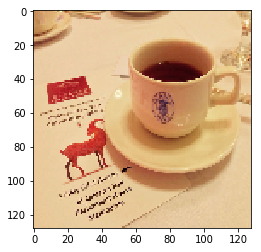

In [38]:
input_folder = sys_config['cup directory'] + "\\val"
files = [x for x in os.listdir(input_folder) if x[-3:] in ["jpg", "png"]]

single_img=cv2.imread(input_folder+'\\'+files[0])
single_img = cv2.cvtColor(single_img, cv2.COLOR_BGR2RGB)
single_img = cv2.resize(single_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)

print(type(single_img))
plt.imshow(single_img)
plt.show

print(single_img.shape)

loading model:  C:\Users\AdamG\OneDrive\Documents\Projects\Uni\FYP\API\keypoint\chkpt\model.ckpt-1000
INFO:tensorflow:Restoring parameters from C:\Users\AdamG\OneDrive\Documents\Projects\Uni\FYP\API\keypoint\chkpt\model.ckpt-1000


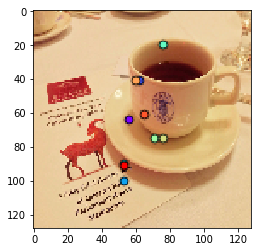

In [39]:
tf.reset_default_graph()

def _default_hparams():
    """Returns default or overridden user-specified hyperparameters."""

    hparams = tf.contrib.training.HParams(
      num_filters=64,  # Number of filters.
      num_kp=10,  # Numer of keypoints.

      loss_pose=0.2,  # Pose Loss.
      loss_con=1.0,  # Multiview consistency Loss.
      loss_sep=1.0,  # Seperation Loss.
      loss_sill=1.0,  # Sillhouette Loss.
      loss_lr=1.0,  # Orientation Loss.
      loss_variance=0.5,  # Variance Loss (part of Sillhouette loss).

      sep_delta=0.05,  # Seperation threshold.
      noise=0.1,  # Noise added during estimating rotation.

      learning_rate=1.0e-3,
      lr_anneal_start=30000,  # When to anneal in the orientation prediction.
      lr_anneal_end=60000,  # When to use the prediction completely.
    )
    return hparams

hp = _default_hparams()

def keypoint_predict(input_img, hparams):
    """Predicts keypoints on all images in input_folder."""

    cols = plt.cm.get_cmap("rainbow")(np.linspace(0, 1.0, hparams.num_kp))[:, :4]

    img = tf.placeholder(tf.float32, shape=(1, 128, 128, 4))

    with tf.variable_scope("KeypointNetwork"):
        ret = kp.keypoint_network(img, hparams.num_filters, hparams.num_kp, False)

    uv = tf.reshape(ret[0], [-1, hparams.num_kp, 2])
    z = tf.reshape(ret[1], [-1, hparams.num_kp, 1])
    uvz = tf.concat([uv, z], axis=2)

    sess = tf.Session()
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(sys_config["kp model dir"])

    print("loading model: ", ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

    output_folder = os.path.join(input_folder, "output")
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)


    orig = input_img.astype(float) / 255
    if orig.shape[2] == 3:
        orig = np.concatenate((orig, np.ones_like(orig[:, :, :1])), axis=2)

    uv_ret = sess.run(uvz, feed_dict={img: np.expand_dims(orig, 0)})

    utils.draw_ndc_points(orig, uv_ret.reshape(hparams.num_kp, 3), cols)
    plt.imshow(orig)

keypoint_predict(single_img, hp)